In [1]:
import gym
import gym_rlio

In [2]:
env = gym.make('rlio-v0')

In [3]:
%%time
env.load_data(
    products_dict={
        4600: [
            555800, 616400, 564900, 582700, 404500, 589400, 582800, 1518900,
            835000, 587400, 617400, 819800, 1843100, 631500, 7562300, 11637400,
            3539700, 3540400, 12906800, 4095600, 886100, 4212800, 706600, 9339400,
            589700, 625700, 560100, 559800, 490400, 1617800, 744200, 720500,
            4285500, 615200, 1453400, 4043300, 571300, 808700, 101300, 6783400
        ]
    }
)


Wall time: 23.4 s


In [4]:
print(env.compute_baseline_realworld())
print('\n---\n')

    store_id  product_id first_appeared last_appeared    sum_reward  \
0       4600      101300     2016-01-01    2019-11-03   -542.859324   
1       4600      404500     2016-01-04    2019-11-29  -8016.940286   
2       4600      490400     2016-01-01    2019-11-03  -2123.190708   
3       4600      555800     2016-01-02    2019-12-30  -4010.350715   
4       4600      559800     2016-01-01    2019-11-03  -6725.942029   
5       4600      560100     2016-01-01    2019-11-03  -4083.642220   
6       4600      564900     2016-01-01    2019-11-29  -1834.571995   
7       4600      571300     2016-01-01    2019-11-03   -274.733561   
8       4600      582700     2016-01-01    2019-11-29 -18774.765919   
9       4600      582800     2016-01-11    2019-11-29   -594.709779   
10      4600      587400     2016-01-01    2019-11-03  -6380.059096   
11      4600      589400     2016-01-10    2019-11-29   -493.943697   
12      4600      589700     2016-01-01    2019-11-03   -631.301787   
13    

<h3>Agent</h3>

In [5]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np

In [6]:
tf.__version__

'2.4.1'

In [7]:
tf.random.set_seed(73)
np.random.seed(73)

In [8]:
num_states = 9
num_actions = 2

upper_bound = [1, 20] # ROL - percentage of OUL
lower_bound = [0, 1] # ROL, OUL

# ROL < OUL


print("Size of State Space ->  {}".format(num_states))
print("Size of Action Space ->  {}".format(num_actions))

print("Max Value of Action ->  {}".format(upper_bound))
print("Min Value of Action ->  {}".format(lower_bound))

Size of State Space ->  9
Size of Action Space ->  2
Max Value of Action ->  [1, 20]
Min Value of Action ->  [0, 1]


In [19]:
# Buffer stores experiences, when the capacity is exceeded, it starts overriding past data

class Buffer:
    def __init__(self, buffer_capacity=100000, batch_size=64):
        # Number of "experiences" to store at max
        self.buffer_capacity = buffer_capacity
        # Num of tuples to train on.
        self.batch_size = batch_size

        # Its tells us num of times record() was called.
        self.buffer_counter = 0

        # Instead of list of tuples as the exp.replay concept go
        # We use different np.arrays for each tuple element
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))

    # Takes (s,a,r,s') obervation tuple as input
    def record(self, obs_tuple):
        # Set index to zero if buffer_capacity is exceeded,
        # replacing old records
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1

    # Eager execution is turned on by default in TensorFlow 2. Decorating with tf.function allows
    # TensorFlow to build a static graph out of the logic and computations in our function.
    # This provides a large speed up for blocks of code that contain many small TensorFlow operations such as this one.
    @tf.function
    def update(
        self, state_batch, action_batch, reward_batch, next_state_batch,
    ):
        # Training and updating Actor & Critic networks.
        # See Pseudo Code.
        with tf.GradientTape() as tape:
            target_actions = target_actor(next_state_batch, training=True)
            y = reward_batch + gamma * target_critic(
                [next_state_batch, target_actions], training=True
            )
            critic_value = critic_model([state_batch, action_batch], training=True)
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
        critic_optimizer.apply_gradients(
            zip(critic_grad, critic_model.trainable_variables)
        )

        with tf.GradientTape() as tape:
            actions = actor_model(state_batch, training=True)
            critic_value = critic_model([state_batch, actions], training=True)
            # Used `-value` as we want to maximize the value given
            # by the critic for our actions
            actor_loss = -tf.math.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables)
        )

    # We compute the loss and update parameters
    def learn(self):
        # Get sampling range
        record_range = min(self.buffer_counter, self.buffer_capacity)
        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.batch_size)

        # Convert to tensors
        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])

        self.update(state_batch, action_batch, reward_batch, next_state_batch)


# This update target parameters slowly
# Based on rate `tau`, which is much less than one.
@tf.function
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))

<h4>Actor + Critic</h4>

In [20]:
def get_actor():
    # Initialize weights between -3e-2 and 3-e2
    last_init = tf.random_uniform_initializer(minval=-0.002, maxval=0.002)

    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(384, activation="relu")(inputs)
    out = layers.Dense(384, activation="relu")(out)
    outputs = layers.Dense(num_actions, activation="sigmoid", kernel_initializer=last_init)(out)

    # Our upper bound
    outputs = outputs * upper_bound
    model = tf.keras.Model(inputs, outputs)
    return model


def get_critic():
    # State as input
    state_input = layers.Input(shape=(num_states))
    state_out = layers.Dense(16, activation="relu")(state_input)
    state_out = layers.Dense(32, activation="relu")(state_out)

    # Action as input
    action_input = layers.Input(shape=(num_actions))
    action_out = layers.Dense(32, activation="relu")(action_input)

    # Both are passed through seperate layer before concatenating
    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(384, activation="relu")(concat)
    out = layers.Dense(384, activation="relu")(out)
    outputs = layers.Dense(1)(out)

    # Outputs single value for give state-action
    model = tf.keras.Model([state_input, action_input], outputs)

    return model

<h4>Policy (take action)</h4>

In [21]:
def policy(state, train=True):
    sampled_actions = tf.squeeze(actor_model(state))
    # Adding noise to actions
    if train:
        sampled_actions = sampled_actions.numpy()
        sampled_actions += np.random.normal(loc=0.0, scale=upper_bound, size=sampled_actions.shape) / max(upper_bound)
    else:
        sampled_actions = sampled_actions.numpy()

    # We make sure action is within bounds
    legal_actions = np.clip(sampled_actions, lower_bound, upper_bound)

    if num_actions == 1:
        return [np.squeeze(legal_actions)]
    else:
        return legal_actions

<h4>Environment Helpers</h4>

In [22]:
def env_reward(rewards):
    return list(rewards[4600].values())

In [23]:
def env_state(states):
    states = list(states[4600].values())
    
    vals = []
    for s in states:
        vals.append([
            s['date'].month,
            s['date'].weekday(),
            s['demand'],
            s['flag_promo'],
            s['lead_time'],
            s['mply_qty'],
            s['sales'],
            s['stock'],
            s['service_level']
        ])
    return np.array(vals)

In [24]:
def env_action(actions):
    if actions.ndim == 1:
        actions = np.array([actions])
    return np.stack((np.floor(np.clip(actions[:, 0] - 1e-8, 0, np.inf) * actions[:, 1]), np.ceil(actions[:, 1])), axis=1)

def return_policy(p, keys):
    return {4600: dict(zip(keys, p.tolist()))}

In [25]:
def save_it_reward_history(history, new):
    for k, v in new[4600].items():
        history[k] = history.get(k, []) + [v]
        
    return history

def save_ep_avg_reward_history(history, ep):
    for k, v in ep.items():
        history[k] = history.get(k, []) + [np.mean(v)]
    return history

def save_ep_sum_reward_history(history, ep):
    for k, v in ep.items():
        history[k] = history.get(k, []) + [np.sum(v)]
    return history

<h4>Initialize agent</h4>

In [26]:
# init actor
actor_model = get_actor()
critic_model = get_critic()

# init critic
target_actor = get_actor()
target_critic = get_critic()

# Making the weights equal initially
target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())

# Learning rate for actor-critic models
critic_optimizer = tf.keras.optimizers.Adam(lr=0.0003)
actor_optimizer = tf.keras.optimizers.Adam(lr=0.0001)

total_episodes = 6
# Discount factor for future rewards
gamma = 0.99
# Used to update target networks
tau = 0.008

buffer = Buffer(100000, 96) # capacity, batch_size

<h4>Simulation</h4>

In [27]:
mag_avg_reward_hist = {}
mag_sum_reward_hist = {}

avg_reward_hist = []
sum_reward_hist = []

ep_rewards = []

for ep in range(total_episodes):
    print('Ep', ep+1, 'starts')
    #
    ep_reward = {'avg': [], 'sum': []}
    ep_reward_hist = {}
    # reset environment
    prev_state, reward, done, _ = env.reset()
    
    i = 0
    while True:
        # convert
        prev_state_arr = env_state(prev_state)
        # tensor
        tf_prev_state = tf.convert_to_tensor(prev_state_arr)
        
        # get policy
        actions = policy(tf_prev_state, train=True)
        
        # convert
        env_actions = env_action(actions)

        
        # Recieve state and reward from environment.
        state, reward, done, _ = env.step(return_policy(env_actions, prev_state[4600].keys()))
        # convert
        state_arr = env_state(state)
        # write to buffer
        for p_s, a, r, s in zip(prev_state_arr, actions, env_reward(reward), state_arr):
            buffer.record((p_s, a, r, s))
            
        # save interation reward stats
        ep_reward_hist = save_it_reward_history(ep_reward_hist, reward)
            
        # learn
        buffer.learn()
        update_target(target_actor.variables, actor_model.variables, tau)
        update_target(target_critic.variables, critic_model.variables, tau)
        
        # End this episode when `done` is True
        if done or i == 1000:
            break
            
        # move forward in time
        prev_state = state
        #
        i = i+1
        
        # debug
        ep_reward['avg'].append(np.mean(list(reward[4600].values())))
        ep_reward['sum'].append(np.sum(list(reward[4600].values())))
        
        if i % 25 == 0:
            avg_ep_reward = np.mean(list(map(lambda x: np.mean(x), list(ep_reward_hist.values()))))
            sum_ep_reward = np.mean(list(map(lambda x: np.sum(x),  list(ep_reward_hist.values()))))
        
        
            print('Debug {}, Avg mean reward: {}, Avg total reward: {}, Action example: {}'\
                  .format(i, np.round(avg_ep_reward, 3), np.round(sum_ep_reward, 3), env_actions[0]))
           
    # ignoring keys, detailed
    ep_rewards.append(ep_reward)
    
    # save episode reward stats (preserving keys)
    mag_avg_reward_hist = save_ep_avg_reward_history(mag_avg_reward_hist, ep_reward_hist)
    mag_sum_reward_hist = save_ep_sum_reward_history(mag_sum_reward_hist, ep_reward_hist)
    
    #################################################
    ############ print debug information ############
    #################################################
    
    # final average episode reward (ignoring keys)
    avg_ep_reward = np.mean(list(map(lambda x: np.mean(x), list(ep_reward_hist.values()))))
    sum_ep_reward = np.mean(list(map(lambda x: np.sum(x),  list(ep_reward_hist.values()))))
    
    avg_reward_hist.append(avg_ep_reward)
    sum_reward_hist.append(sum_ep_reward)
    
    
    print("---> Episode * {} * Avg Mean Reward is ==> {} * Avg Total Reward is ==> {}"\
         .format(ep+1, np.round(avg_ep_reward, 3), np.round(sum_ep_reward, 3)))

Ep 1 starts
Debug 25, Avg mean reward: -1.475, Avg total reward: -36.631, Action example: [3. 8.]
Debug 50, Avg mean reward: -1.283, Avg total reward: -63.767, Action example: [1. 6.]
Debug 75, Avg mean reward: -1.182, Avg total reward: -88.298, Action example: [0. 1.]
Debug 100, Avg mean reward: -1.04, Avg total reward: -103.694, Action example: [0. 1.]
Debug 125, Avg mean reward: -0.927, Avg total reward: -115.571, Action example: [0. 1.]
Debug 150, Avg mean reward: -0.843, Avg total reward: -126.143, Action example: [0. 1.]
Debug 175, Avg mean reward: -0.778, Avg total reward: -135.854, Action example: [0. 1.]
Debug 200, Avg mean reward: -0.726, Avg total reward: -144.976, Action example: [0. 1.]
Debug 225, Avg mean reward: -0.691, Avg total reward: -155.246, Action example: [1. 2.]
Debug 250, Avg mean reward: -0.654, Avg total reward: -163.301, Action example: [1. 2.]
Debug 275, Avg mean reward: -0.613, Avg total reward: -168.544, Action example: [0. 1.]
Debug 300, Avg mean reward:

Debug 325, Avg mean reward: -0.012, Avg total reward: -3.806, Action example: [0. 1.]
Debug 350, Avg mean reward: -0.007, Avg total reward: -2.553, Action example: [0. 1.]
Debug 375, Avg mean reward: -0.008, Avg total reward: -3.211, Action example: [0. 2.]
Debug 400, Avg mean reward: -0.012, Avg total reward: -4.707, Action example: [0. 6.]
Debug 425, Avg mean reward: -0.014, Avg total reward: -5.897, Action example: [0. 1.]
Debug 450, Avg mean reward: -0.019, Avg total reward: -8.391, Action example: [0. 1.]
Debug 475, Avg mean reward: -0.027, Avg total reward: -12.956, Action example: [0. 1.]
Debug 500, Avg mean reward: -0.036, Avg total reward: -18.018, Action example: [0. 1.]
Debug 525, Avg mean reward: -0.047, Avg total reward: -24.49, Action example: [0. 1.]
Debug 550, Avg mean reward: -0.057, Avg total reward: -31.632, Action example: [0. 2.]
Debug 575, Avg mean reward: -0.065, Avg total reward: -37.385, Action example: [0. 1.]
Debug 600, Avg mean reward: -0.07, Avg total rewar

Debug 650, Avg mean reward: -0.078, Avg total reward: -50.437, Action example: [0. 1.]
Debug 675, Avg mean reward: -0.078, Avg total reward: -52.735, Action example: [0. 1.]
Debug 700, Avg mean reward: -0.079, Avg total reward: -55.426, Action example: [0. 1.]
Debug 725, Avg mean reward: -0.078, Avg total reward: -56.402, Action example: [0. 1.]
Debug 750, Avg mean reward: -0.078, Avg total reward: -58.259, Action example: [0. 2.]
Debug 775, Avg mean reward: -0.079, Avg total reward: -60.951, Action example: [0. 2.]
Debug 800, Avg mean reward: -0.079, Avg total reward: -63.282, Action example: [0. 1.]
Debug 825, Avg mean reward: -0.079, Avg total reward: -64.996, Action example: [0. 1.]
Debug 850, Avg mean reward: -0.08, Avg total reward: -67.608, Action example: [0. 1.]
Debug 875, Avg mean reward: -0.081, Avg total reward: -71.139, Action example: [0. 6.]
Debug 900, Avg mean reward: -0.085, Avg total reward: -76.285, Action example: [0. 1.]
Debug 925, Avg mean reward: -0.087, Avg tota

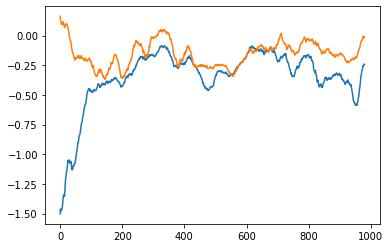

In [32]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

plt.plot(moving_average(ep_rewards[0]['avg'], 20))
plt.plot(moving_average(ep_rewards[1]['avg'], 20))

In [28]:
import json

with open('./hist/DDPG_valid_9.json', mode='w') as f:
    json.dump({
        'avg': mag_avg_reward_hist,
        'sum': mag_sum_reward_hist,
        'ep': ep_rewards
    }, f, indent=2)

In [29]:
actor_model.save('actor_model_v9.h5')

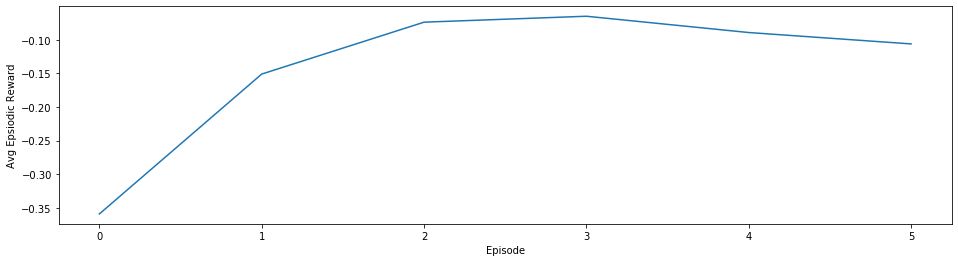

In [33]:
import matplotlib.pyplot as plt
# Plotting graph
# Episodes versus Avg. Rewards
plt.figure(figsize=(16,4));
plt.plot(avg_reward_hist);
plt.xlabel("Episode")
plt.ylabel("Avg Epsiodic Reward")
plt.show()

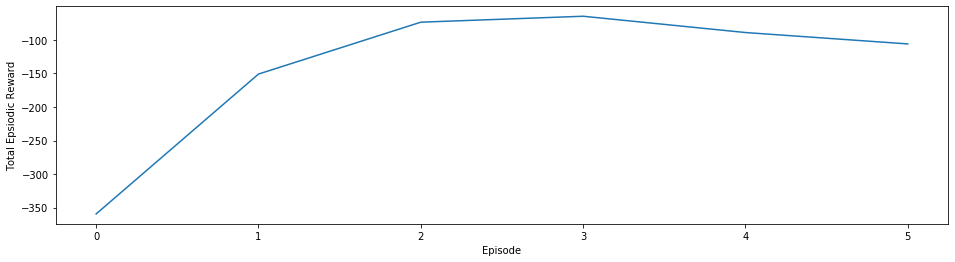

In [34]:
import matplotlib.pyplot as plt
# Plotting graph
# Episodes versus Avg. Rewards
plt.figure(figsize=(16,4));
plt.plot(sum_reward_hist);
plt.xlabel("Episode")
plt.ylabel("Total Epsiodic Reward")
plt.show()

<h3>Validation</h3>

In [45]:
val_mag_avg_reward_hist = {}
val_mag_sum_reward_hist = {}

val_avg_reward_hist = []
val_sum_reward_hist = []

val_ep_rewards = []

for ep in range(1):
    print('Ep', ep+1, 'starts')
    #
    ep_reward = {'avg': [], 'sum': []}
    ep_reward_hist = {}
    # reset environment
    prev_state, reward, done, _ = env.reset()
    
    i = 0
    while True:
        # convert
        prev_state_arr = env_state(prev_state)
        # tensor
        tf_prev_state = tf.convert_to_tensor(prev_state_arr)
        
        # get policy
        actions = policy(tf_prev_state, train=True)
        
        # convert
        env_actions = env_action(actions)
        
        # Recieve state and reward from environment.
        state, reward, done, _ = env.step(return_policy(env_actions, prev_state[4600].keys()))
        # convert
        state_arr = env_state(state)
        
        if i > 1000:
            # save interation reward stats
            ep_reward_hist = save_it_reward_history(ep_reward_hist, reward)
        
        # End this episode when `done` is True
        if done:
            break
            
        # move forward in time
        prev_state = state
        #
        i = i+1
        # debug
        ep_reward['avg'].append(np.mean(list(reward[4600].values())))
        ep_reward['sum'].append(np.sum(list(reward[4600].values())))
        
        if i % 25 == 0:
            avg_ep_reward = np.mean(list(map(lambda x: np.mean(x), list(ep_reward_hist.values()))))
            sum_ep_reward = np.mean(list(map(lambda x: np.sum(x),  list(ep_reward_hist.values()))))
            
            print('Debug {}, Avg mean reward: {}, Avg total reward: {}, Action example: {}'\
                  .format(i, np.round(avg_ep_reward, 3), np.round(sum_ep_reward, 3), env_actions[0]))
            
    # ignoring keys, detailed
    val_ep_rewards.append(ep_reward)
            
    # save episode reward stats (preserving keys)
    val_mag_avg_reward_hist = save_ep_avg_reward_history(val_mag_avg_reward_hist, ep_reward_hist)
    val_mag_sum_reward_hist = save_ep_sum_reward_history(val_mag_sum_reward_hist, ep_reward_hist)
    
    #################################################
    ############ print debug information ############
    #################################################
    
    # final average episode reward (ignoring keys)
    avg_ep_reward = np.mean(list(map(lambda x: np.mean(x), list(ep_reward_hist.values()))))
    sum_ep_reward = np.mean(list(map(lambda x: np.sum(x),  list(ep_reward_hist.values()))))
    
    val_avg_reward_hist.append(avg_ep_reward)
    val_sum_reward_hist.append(sum_ep_reward)
    
    
    print("---> Episode * {} * Avg Mean Reward is ==> {} * Avg Total Reward is ==> {}"\
         .format(ep+1, np.round(avg_ep_reward, 3), np.round(sum_ep_reward, 3)))

Ep 1 starts
Debug 25, Avg mean reward: nan, Avg total reward: nan, Action example: [0. 3.]
Debug 50, Avg mean reward: nan, Avg total reward: nan, Action example: [0. 1.]
Debug 75, Avg mean reward: nan, Avg total reward: nan, Action example: [0. 2.]
Debug 100, Avg mean reward: nan, Avg total reward: nan, Action example: [0. 1.]
Debug 125, Avg mean reward: nan, Avg total reward: nan, Action example: [0. 1.]
Debug 150, Avg mean reward: nan, Avg total reward: nan, Action example: [0. 2.]
Debug 175, Avg mean reward: nan, Avg total reward: nan, Action example: [0. 1.]
Debug 200, Avg mean reward: nan, Avg total reward: nan, Action example: [0. 1.]
Debug 225, Avg mean reward: nan, Avg total reward: nan, Action example: [0. 1.]
Debug 250, Avg mean reward: nan, Avg total reward: nan, Action example: [0. 1.]
Debug 275, Avg mean reward: nan, Avg total reward: nan, Action example: [0. 1.]
Debug 300, Avg mean reward: nan, Avg total reward: nan, Action example: [0. 1.]
Debug 325, Avg mean reward: nan

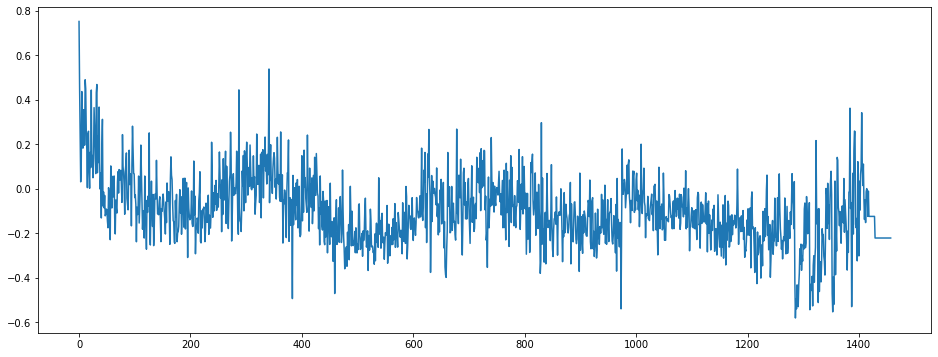

In [46]:
plt.figure(figsize=(16,6))
plt.plot(val_ep_rewards[0]['avg']);

In [47]:
import json

with open('./hist/DDPG_valid_9.json', mode='w') as f:
    json.dump({
        'avg': mag_avg_reward_hist,
        'sum': mag_sum_reward_hist,
        'ep': ep_rewards,
        
        'val_avg': val_mag_avg_reward_hist,
        'val_sum': val_mag_sum_reward_hist,
        'val_ep': val_ep_rewards,
    }, f, indent=2)

In [38]:
import time

prev_state, reward, done, _ = env.reset()
episodic_reward = 0

i = 0
while True:
    prev_state_arr = env_state(prev_state)
    tf_prev_state = tf.convert_to_tensor(prev_state_arr)

    actions = policy(tf_prev_state, False)
    # convert
    env_actions = env_action(actions)

    # Recieve state and reward from environment.
    state, reward, done, _ = env.step(return_policy(env_actions, prev_state[4600].keys()))
    # convert
    state_arr = env_state(state)

    # End this episode when `done` is True
    if done:
        break

    prev_state = state
    i = i+1

    if i % 1 == 0:
        env.render()
        
        time.sleep(1)

02.01.2016 (Day 2 of 1460)
-------------------------------------------------------------------------------------------------------
Store      | SKU        | Current Stock | Next Order | Last Policy | Last Reward | Sum Reward          
-------------------------------------------------------------------------------------------------------
      4600 |     101300 | 1             |          0 | [0.0, 1.0]  |        0.89 |              -208.53
      4600 |     404500 | 1             |          0 | [0.0, 1.0]  |       -0.11 |             -2735.45
      4600 |     490400 | 0             |          1 | [0.0, 1.0]  |        0.80 |             -6630.58
      4600 |     555800 | 1             |          0 | [0.0, 1.0]  |       -0.11 |               -86.08
      4600 |     559800 | 0             |         13 | [0.0, 13.0] |       -2.00 |              7417.89
      4600 |     560100 | 3             |          0 | [0.0, 1.0]  |       -0.62 |             -3769.96
      4600 |     564900 | 0          

04.01.2016 (Day 4 of 1460)
-------------------------------------------------------------------------------------------------------
Store      | SKU        | Current Stock | Next Order | Last Policy | Last Reward | Sum Reward          
-------------------------------------------------------------------------------------------------------
      4600 |     101300 | 1             |          0 | [0.0, 1.0]  |       -0.11 |              -208.76
      4600 |     404500 | 1             |          0 | [0.0, 1.0]  |       -0.11 |             -2735.45
      4600 |     490400 | 1             |          0 | [0.0, 1.0]  |       -0.67 |             -6631.91
      4600 |     555800 | 0             |          1 | [0.0, 1.0]  |        0.65 |               -84.68
      4600 |     559800 | 3             |          0 | [0.0, 1.0]  |        3.67 |              7426.78
      4600 |     560100 | 3             |          0 | [0.0, 1.0]  |       -1.62 |             -3773.19
      4600 |     564900 | 0          

06.01.2016 (Day 6 of 1460)
-------------------------------------------------------------------------------------------------------
Store      | SKU        | Current Stock | Next Order | Last Policy | Last Reward | Sum Reward          
-------------------------------------------------------------------------------------------------------
      4600 |     101300 | 1             |          0 | [0.0, 1.0]  |       -0.11 |              -208.98
      4600 |     404500 | 2             |          0 | [0.0, 1.0]  |       -1.33 |             -2736.23
      4600 |     490400 | 1             |          0 | [0.0, 1.0]  |       -0.67 |             -6633.25
      4600 |     555800 | 2             |          0 | [0.0, 1.0]  |       -0.63 |               -84.76
      4600 |     559800 | 0             |          7 | [0.0, 7.0]  |        1.45 |              7430.53
      4600 |     560100 | 3             |          0 | [0.0, 1.0]  |       -1.62 |             -3776.42
      4600 |     564900 | 1          

08.01.2016 (Day 8 of 1460)
-------------------------------------------------------------------------------------------------------
Store      | SKU        | Current Stock | Next Order | Last Policy | Last Reward | Sum Reward          
-------------------------------------------------------------------------------------------------------
      4600 |     101300 | 1             |          0 | [0.0, 1.0]  |       -0.11 |              -209.20
      4600 |     404500 | 0             |          1 | [0.0, 1.0]  |        0.80 |             -2733.63
      4600 |     490400 | 1             |          0 | [0.0, 1.0]  |       -0.67 |             -6634.58
      4600 |     555800 | 0             |          1 | [0.0, 1.0]  |        0.80 |               -83.28
      4600 |     559800 | 0             |          5 | [0.0, 5.0]  |        3.90 |              7440.43
      4600 |     560100 | 3             |          0 | [0.0, 2.0]  |       -1.62 |             -3779.65
      4600 |     564900 | 0          

10.01.2016 (Day 10 of 1460)
-------------------------------------------------------------------------------------------------------
Store      | SKU        | Current Stock | Next Order | Last Policy | Last Reward | Sum Reward          
-------------------------------------------------------------------------------------------------------
      4600 |     101300 | 2             |          0 | [0.0, 1.0]  |       -0.22 |              -208.82
      4600 |     404500 | 0             |          1 | [0.0, 1.0]  |        0.70 |             -2732.13
      4600 |     490400 | 1             |          0 | [0.0, 1.0]  |       -0.67 |             -6634.45
      4600 |     555800 | 0             |          1 | [0.0, 1.0]  |        0.75 |               -81.83
      4600 |     559800 | 0             |          1 | [0.0, 1.0]  |        0.70 |              7445.02
      4600 |     560100 | 3             |          0 | [0.0, 1.0]  |       -1.62 |             -3782.88
      4600 |     564900 | 0         

12.01.2016 (Day 12 of 1460)
-------------------------------------------------------------------------------------------------------
Store      | SKU        | Current Stock | Next Order | Last Policy | Last Reward | Sum Reward          
-------------------------------------------------------------------------------------------------------
      4600 |     101300 | 2             |          0 | [0.0, 1.0]  |       -0.22 |              -207.49
      4600 |     404500 | 0             |          1 | [0.0, 1.0]  |        0.80 |             -2732.00
      4600 |     490400 | 1             |          0 | [0.0, 1.0]  |       -0.67 |             -6635.78
      4600 |     555800 | 0             |          1 | [0.0, 1.0]  |        0.80 |               -80.23
      4600 |     559800 | 0             |         19 | [0.0, 19.0] |        1.80 |              7446.32
      4600 |     560100 | 3             |          0 | [0.0, 1.0]  |       -1.62 |             -3786.11
      4600 |     564900 | 0         

14.01.2016 (Day 14 of 1460)
-------------------------------------------------------------------------------------------------------
Store      | SKU        | Current Stock | Next Order | Last Policy | Last Reward | Sum Reward          
-------------------------------------------------------------------------------------------------------
      4600 |     101300 | 2             |          0 | [0.0, 1.0]  |       -0.22 |              -207.94
      4600 |     404500 | 10            |          0 | [0.0, 1.0]  |       -4.67 |             -2738.36
      4600 |     490400 | 0             |          1 | [0.0, 1.0]  |        0.80 |             -6635.65
      4600 |     555800 | 0             |          1 | [0.0, 1.0]  |        1.80 |               -77.88
      4600 |     559800 | 6             |          0 | [0.0, 16.0] |       13.33 |              7474.40
      4600 |     560100 | 3             |          0 | [0.0, 2.0]  |       -1.62 |             -3789.35
      4600 |     564900 | 2         

16.01.2016 (Day 16 of 1460)
-------------------------------------------------------------------------------------------------------
Store      | SKU        | Current Stock | Next Order | Last Policy | Last Reward | Sum Reward          
-------------------------------------------------------------------------------------------------------
      4600 |     101300 | 1             |          0 | [0.0, 1.0]  |       -0.11 |              -207.16
      4600 |     404500 | 8             |          0 | [0.0, 2.0]  |       -3.33 |             -2748.36
      4600 |     490400 | 1             |          0 | [0.0, 1.0]  |       -0.67 |             -6636.98
      4600 |     555800 | 0             |          3 | [0.0, 3.0]  |        1.25 |               -76.13
      4600 |     559800 | 0             |          5 | [0.0, 5.0]  |        0.80 |              7480.70
      4600 |     560100 | 3             |          0 | [0.0, 1.0]  |       -1.62 |             -3792.58
      4600 |     564900 | 0         

18.01.2016 (Day 18 of 1460)
-------------------------------------------------------------------------------------------------------
Store      | SKU        | Current Stock | Next Order | Last Policy | Last Reward | Sum Reward          
-------------------------------------------------------------------------------------------------------
      4600 |     101300 | 2             |          0 | [0.0, 1.0]  |       -0.22 |              -206.78
      4600 |     404500 | 5             |          0 | [0.0, 2.0]  |       -2.33 |             -2752.70
      4600 |     490400 | 1             |          0 | [0.0, 1.0]  |       -0.67 |             -6638.31
      4600 |     555800 | 0             |          1 | [0.0, 1.0]  |        0.70 |               -73.74
      4600 |     559800 | 0             |          1 | [0.0, 1.0]  |        1.70 |              7485.18
      4600 |     560100 | 3             |          0 | [0.0, 1.0]  |       -1.62 |             -3795.81
      4600 |     564900 | 0         

20.01.2016 (Day 20 of 1460)
-------------------------------------------------------------------------------------------------------
Store      | SKU        | Current Stock | Next Order | Last Policy | Last Reward | Sum Reward          
-------------------------------------------------------------------------------------------------------
      4600 |     101300 | 2             |          0 | [0.0, 1.0]  |       -0.22 |              -207.23
      4600 |     404500 | 2             |          0 | [0.0, 1.0]  |       -1.33 |             -2752.36
      4600 |     490400 | 1             |          0 | [0.0, 1.0]  |       -0.67 |             -6639.65
      4600 |     555800 | 1             |          0 | [0.0, 1.0]  |        0.68 |               -72.51
      4600 |     559800 | 5             |          0 | [0.0, 1.0]  |       -0.56 |              7484.48
      4600 |     560100 | 3             |          0 | [0.0, 1.0]  |       -1.62 |             -3799.04
      4600 |     564900 | 4         

22.01.2016 (Day 22 of 1460)
-------------------------------------------------------------------------------------------------------
Store      | SKU        | Current Stock | Next Order | Last Policy | Last Reward | Sum Reward          
-------------------------------------------------------------------------------------------------------
      4600 |     101300 | 2             |          0 | [0.0, 1.0]  |       -0.22 |              -207.67
      4600 |     404500 | 0             |          1 | [0.0, 1.0]  |        0.80 |             -2751.23
      4600 |     490400 | 0             |          1 | [0.0, 1.0]  |        0.80 |             -6639.51
      4600 |     555800 | 0             |          1 | [0.0, 1.0]  |        0.75 |               -72.07
      4600 |     559800 | 0             |          2 | [0.0, 2.0]  |        0.50 |              7489.78
      4600 |     560100 | 3             |          0 | [0.0, 2.0]  |       -1.62 |             -3802.27
      4600 |     564900 | 0         

24.01.2016 (Day 24 of 1460)
-------------------------------------------------------------------------------------------------------
Store      | SKU        | Current Stock | Next Order | Last Policy | Last Reward | Sum Reward          
-------------------------------------------------------------------------------------------------------
      4600 |     101300 | 2             |          0 | [0.0, 1.0]  |       -0.22 |              -208.12
      4600 |     404500 | 0             |          1 | [0.0, 1.0]  |        0.75 |             -2749.68
      4600 |     490400 | 1             |          0 | [0.0, 1.0]  |       -0.67 |             -6640.85
      4600 |     555800 | 0             |          1 | [0.0, 1.0]  |        0.75 |               -70.57
      4600 |     559800 | 0             |          4 | [0.0, 4.0]  |       -0.00 |              7491.58
      4600 |     560100 | 3             |          0 | [0.0, 1.0]  |       -1.62 |             -3805.50
      4600 |     564900 | 0         

26.01.2016 (Day 26 of 1460)
-------------------------------------------------------------------------------------------------------
Store      | SKU        | Current Stock | Next Order | Last Policy | Last Reward | Sum Reward          
-------------------------------------------------------------------------------------------------------
      4600 |     101300 | 1             |          0 | [0.0, 1.0]  |        0.89 |              -207.45
      4600 |     404500 | 0             |          1 | [0.0, 1.0]  |        0.80 |             -2748.08
      4600 |     490400 | 0             |          1 | [0.0, 1.0]  |        0.80 |             -6640.71
      4600 |     555800 | 0             |          4 | [0.0, 4.0]  |        0.10 |               -69.67
      4600 |     559800 | 0             |          4 | [0.0, 4.0]  |        1.05 |              7494.40
      4600 |     560100 | 3             |          0 | [0.0, 1.0]  |       -1.62 |             -3808.73
      4600 |     564900 | 1         

28.01.2016 (Day 28 of 1460)
-------------------------------------------------------------------------------------------------------
Store      | SKU        | Current Stock | Next Order | Last Policy | Last Reward | Sum Reward          
-------------------------------------------------------------------------------------------------------
      4600 |     101300 | 1             |          0 | [0.0, 1.0]  |       -0.11 |              -207.67
      4600 |     404500 | 1             |          0 | [0.0, 1.0]  |       -0.67 |             -2749.41
      4600 |     490400 | 1             |          0 | [0.0, 1.0]  |       -0.67 |             -6642.05
      4600 |     555800 | 1             |          0 | [0.0, 1.0]  |       -0.32 |               -67.31
      4600 |     559800 | 0             |          8 | [0.0, 8.0]  |       -0.90 |              7496.39
      4600 |     560100 | 2             |          0 | [0.0, 1.0]  |       -0.08 |             -3810.42
      4600 |     564900 | 8         

30.01.2016 (Day 30 of 1460)
-------------------------------------------------------------------------------------------------------
Store      | SKU        | Current Stock | Next Order | Last Policy | Last Reward | Sum Reward          
-------------------------------------------------------------------------------------------------------
      4600 |     101300 | 1             |          0 | [0.0, 1.0]  |       -0.11 |              -207.89
      4600 |     404500 | 0             |          1 | [0.0, 1.0]  |        0.80 |             -2747.86
      4600 |     490400 | 1             |          0 | [0.0, 1.0]  |       -0.67 |             -6643.38
      4600 |     555800 | 0             |          1 | [0.0, 1.0]  |        1.80 |               -65.01
      4600 |     559800 | 11            |          0 | [0.0, 1.0]  |        0.78 |              7502.42
      4600 |     560100 | 2             |          0 | [0.0, 1.0]  |       -1.08 |             -3812.58
      4600 |     564900 | 0         

01.02.2016 (Day 32 of 1460)
-------------------------------------------------------------------------------------------------------
Store      | SKU        | Current Stock | Next Order | Last Policy | Last Reward | Sum Reward          
-------------------------------------------------------------------------------------------------------
      4600 |     101300 | 1             |          0 | [0.0, 1.0]  |       -0.11 |              -208.12
      4600 |     404500 | 0             |          1 | [0.0, 1.0]  |        0.75 |             -2747.78
      4600 |     490400 | 1             |          0 | [0.0, 1.0]  |       -0.67 |             -6644.71
      4600 |     555800 | 0             |          1 | [0.0, 1.0]  |        0.80 |               -63.51
      4600 |     559800 | 1             |          0 | [0.0, 1.0]  |        0.89 |              7513.76
      4600 |     560100 | 2             |          0 | [0.0, 1.0]  |       -1.08 |             -3814.73
      4600 |     564900 | 0         

03.02.2016 (Day 34 of 1460)
-------------------------------------------------------------------------------------------------------
Store      | SKU        | Current Stock | Next Order | Last Policy | Last Reward | Sum Reward          
-------------------------------------------------------------------------------------------------------
      4600 |     101300 | 0             |          2 | [0.0, 1.0]  |        0.60 |              -207.63
      4600 |     404500 | 0             |          1 | [0.0, 1.0]  |        0.80 |             -2747.65
      4600 |     490400 | 1             |          0 | [0.0, 1.0]  |       -0.67 |             -6646.05
      4600 |     555800 | 1             |          0 | [0.0, 1.0]  |        0.68 |               -62.27
      4600 |     559800 | 3             |          0 | [0.0, 14.0] |       11.67 |              7523.03
      4600 |     560100 | 1             |          0 | [0.0, 1.0]  |       -0.54 |             -3814.81
      4600 |     564900 | 0         

05.02.2016 (Day 36 of 1460)
-------------------------------------------------------------------------------------------------------
Store      | SKU        | Current Stock | Next Order | Last Policy | Last Reward | Sum Reward          
-------------------------------------------------------------------------------------------------------
      4600 |     101300 | 2             |          0 | [0.0, 1.0]  |       -0.22 |              -208.07
      4600 |     404500 | 0             |          1 | [0.0, 1.0]  |        0.75 |             -2747.56
      4600 |     490400 | 1             |          0 | [0.0, 1.0]  |       -0.67 |             -6647.38
      4600 |     555800 | 0             |          1 | [0.0, 1.0]  |        0.75 |               -60.72
      4600 |     559800 | 0             |         15 | [0.0, 15.0] |       -1.50 |              7522.30
      4600 |     560100 | 0             |          1 | [0.0, 1.0]  |        0.80 |             -3814.55
      4600 |     564900 | 0         

07.02.2016 (Day 38 of 1460)
-------------------------------------------------------------------------------------------------------
Store      | SKU        | Current Stock | Next Order | Last Policy | Last Reward | Sum Reward          
-------------------------------------------------------------------------------------------------------
      4600 |     101300 | 1             |          0 | [0.0, 1.0]  |        0.89 |              -207.41
      4600 |     404500 | 0             |          1 | [0.0, 1.0]  |        0.80 |             -2747.43
      4600 |     490400 | 1             |          0 | [0.0, 1.0]  |       -0.67 |             -6648.71
      4600 |     555800 | 0             |          1 | [0.0, 1.0]  |        0.75 |               -59.27
      4600 |     559800 | 0             |          1 | [0.0, 1.0]  |        7.80 |              7536.21
      4600 |     560100 | 0             |          1 | [0.0, 1.0]  |        3.80 |             -3810.75
      4600 |     564900 | 1         

09.02.2016 (Day 40 of 1460)
-------------------------------------------------------------------------------------------------------
Store      | SKU        | Current Stock | Next Order | Last Policy | Last Reward | Sum Reward          
-------------------------------------------------------------------------------------------------------
      4600 |     101300 | 1             |          0 | [0.0, 1.0]  |        0.89 |              -205.92
      4600 |     404500 | 0             |          1 | [0.0, 1.0]  |        0.80 |             -2745.83
      4600 |     490400 | 1             |          0 | [0.0, 1.0]  |       -0.67 |             -6650.05
      4600 |     555800 | 0             |          1 | [0.0, 1.0]  |        0.80 |               -57.67
      4600 |     559800 | 6             |          0 | [0.0, 2.0]  |        1.33 |              7536.60
      4600 |     560100 | 0             |          1 | [0.0, 1.0]  |        0.80 |             -3810.48
      4600 |     564900 | 1         

11.02.2016 (Day 42 of 1460)
-------------------------------------------------------------------------------------------------------
Store      | SKU        | Current Stock | Next Order | Last Policy | Last Reward | Sum Reward          
-------------------------------------------------------------------------------------------------------
      4600 |     101300 | 1             |          0 | [0.0, 1.0]  |       -0.11 |              -206.14
      4600 |     404500 | 0             |          1 | [0.0, 1.0]  |        0.80 |             -2745.70
      4600 |     490400 | 1             |          0 | [0.0, 1.0]  |       -0.67 |             -6651.38
      4600 |     555800 | 3             |          0 | [0.0, 1.0]  |        0.05 |               -57.57
      4600 |     559800 | 0             |          6 | [0.0, 6.0]  |        1.55 |              7540.81
      4600 |     560100 | 1             |          0 | [0.0, 1.0]  |       -0.54 |             -3810.22
      4600 |     564900 | 2         

13.02.2016 (Day 44 of 1460)
-------------------------------------------------------------------------------------------------------
Store      | SKU        | Current Stock | Next Order | Last Policy | Last Reward | Sum Reward          
-------------------------------------------------------------------------------------------------------
      4600 |     101300 | 2             |          0 | [0.0, 1.0]  |       -0.22 |              -205.76
      4600 |     404500 | 1             |          0 | [0.0, 1.0]  |       -0.67 |             -2747.03
      4600 |     490400 | 1             |          0 | [0.0, 1.0]  |       -0.67 |             -6652.71
      4600 |     555800 | 0             |          1 | [0.0, 1.0]  |        0.75 |               -54.07
      4600 |     559800 | 0             |         17 | [0.0, 17.0] |       -3.00 |              7542.70
      4600 |     560100 | 1             |          0 | [0.0, 1.0]  |       -0.54 |             -3811.30
      4600 |     564900 | 0         

KeyboardInterrupt: 